# NYPD Motor Vehicle Accidents 
In this notebook we analyze the "NYPD Motor Vehicle Collisions" data set provided by NYC Open Data.

##### This notebook does:
    1. Installing additional Python packages
    2. Adding external PySpark module.
    3. Descriptive Analysis
       3.1 Investigating the data attributes with Spark
       3.2 Plots data and results with matplotlib
    4. Data selection and shaping using Spark
    

## Data Set

You can access and download the "NYPD Motor Vehicle Collisions" by clicking on this [link](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95), go to "Export" and download the data set as CSV file. 

This data set covers all reported vehicle collisions from July 2012 until now and contains detailed information about the incidents.

After the download, you can upload the CSV file through the **Data Source** tab on the right. Wait until the file is completely uploaded, this may take about 5 minutes. This file is now stored in your Object Storage service that is associated with your IBM Analytics for Apache Spark service, so that it can be used by the following code.


## Set Configuration for accessing Object Storage
This following cell defines the function to set the configuration with your Object Storage service credentials.

Note: We are not using Hadoop in this sample, however Spark leverages some Hadoop components.

In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v2.0/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

Click the following cell, so that it gets focus. Now, in the **Data Sources** tab use the **Insert to code** function on your uploaded CSV file to insert the credentials.

In [ ]:
auth_url : 
project : 
project_id : 
region : 
user_id : 
domain_id : 
domain_name : 
username : 
password : 
filename : 
container : 
tenantId : 


Copy the inserted credentials into the Python dictionary below to use later.

In [2]:
credentials = {
    'auth_url': '',
    'project_id': '',
    'region': '',
    'user_id': '',
    'username': '',
    'password': '',
    'filename': '',
    'container': ''
}

Set Hadoop configuration with name="keystone". You can use any name.

In [3]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

## Load Data

Instead of programatically specifying the schema for a `Spark DataFrame`, we use `pyspark-csv`. It is an external module for `PySpark` and it works like Panda's `read_csv`. We load the NYPD motor vehicle collisions data set from Object Storage as `RDD` and create a `Spark DataFrame` from it.

In [4]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

collisions = sc.textFile("swift://notebooks." + credentials['name'] + "/NYPD_Motor_Vehicle_Collisions.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

collisions_header = collisions.first()


collisions_header_list = collisions_header.split(",")
collisions_body = collisions.mapPartitionsWithIndex(skip_header)

# filter not valid rows
collisions_body = collisions_body.filter(lambda line : len(line.split(","))>29)

# create Spark DataFrame using pyspark-csv
collisions_df = pycsv.csvToDataFrame(sqlContext, collisions_body, sep=",", columns=collisions_header_list)

Now that the data is loaded, check the inferred schema.

In [6]:
# Python expressions in a code cell will be outputted after computation
collisions_df.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string 

Let have us a first look on the data itself.

In [7]:
collisions_df.take(1)

[Row(DATE=datetime.datetime(2013, 6, 17, 0, 0), TIME=datetime.datetime(2015, 12, 8, 16, 0), BOROUGH=u'BROOKLYN', ZIP CODE=11215, LATITUDE=40.6718642, LONGITUDE=-73.9708541, LOCATION=u'(40.6718642, -73.9708541)', ON STREET NAME=u'PRESIDENT STREET', CROSS STREET NAME=u'PROSPECT PARK WEST', OFF STREET NAME=None, NUMBER OF PERSONS INJURED=0, NUMBER OF PERSONS KILLED=0, NUMBER OF PEDESTRIANS INJURED=0, NUMBER OF PEDESTRIANS KILLED=0, NUMBER OF CYCLIST INJURED=0, NUMBER OF CYCLIST KILLED=0, NUMBER OF MOTORIST INJURED=0, NUMBER OF MOTORIST KILLED=0, CONTRIBUTING FACTOR VEHICLE 1=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 2=None, CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=177805, VEHICLE TYPE CODE 1=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 2=None, VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None)]

Run the following cell to count the number of collisions.

In [8]:
collisions_df.count()

598841

## Visualization Packages

To plot data, this notebook uses the following two packages:

- [Matplotlib](http://www.matplotlib.org/), a basic plotting library for Python
- [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/), a statistical data visualization library


We have to install `seaborn` using `!pip`.

In [9]:
!pip install --user seaborn

You are using pip version 7.1.0, however version 7.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 147kB 968kB/s 
  Running setup.py install for seaborn


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import pandas as pd

## Data Exploration and Plots
Now that the data is loaded, we can start exploring the data and visualizing patterns. In the code cell below, we select certain columns of the data and transform them into a `pandas DataFrame`.

In [11]:
collisions_pd = collisions_df[collisions_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME',
                                                               'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                               'CONTRIBUTING FACTOR VEHICLE 1']].toPandas()

collisions_pd.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

#divide dataset in accidents which are: fatal, non-lethal but with person damage, non of the above
killed_pd = collisions_pd[collisions_pd['Persons Killed']!=0]
injured_pd = collisions_pd[np.logical_and(collisions_pd['Persons Injured']!=0, collisions_pd['Persons Killed']==0)]
nothing_pd = collisions_pd[np.logical_and(collisions_pd['Persons Killed']==0, collisions_pd['Persons Injured']==0)]

### Motor vehicle collisions in New York City
We can create an intial explorative scatterplot of all collisions by using the latitude and longitude from the raw data.

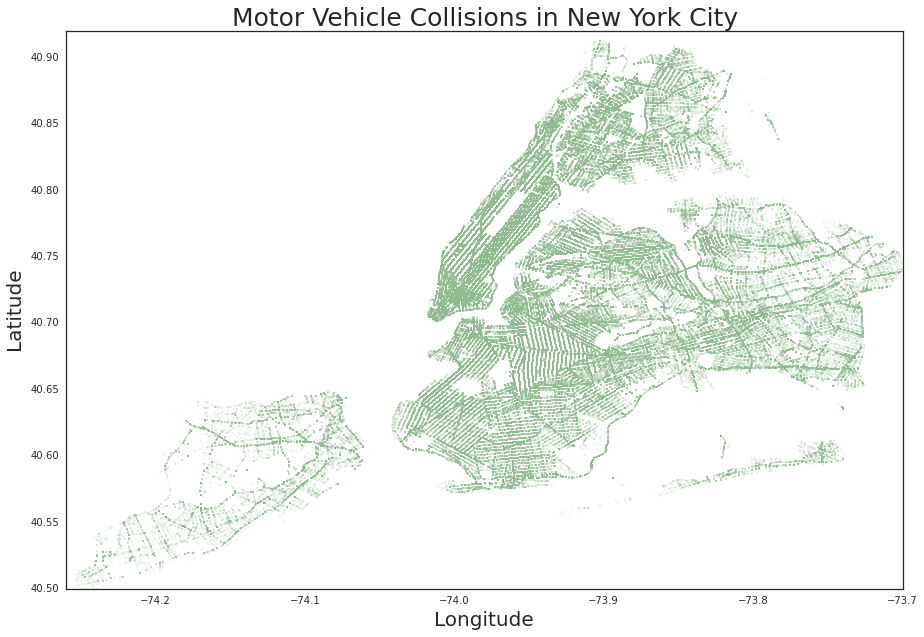

In [12]:
#adjust settings
sns.set_style("white")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(collisions_pd.Longitude, collisions_pd.Latitude, alpha=0.05, s=4, color='darkseagreen')

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

Although this scatter plot is not a street map of New York City, you will notice that the scatter plot dots roughly correspond to the street map of New York City. We can see that very few collisions happen in Central Park and on bridges. We can see higher density of collisions in areas such street crossings and curves.

### Motor vehicle collisions in New York City by borough
Now let's add information about the city boroughs and use a different color to depict each borough on the scatter plot. 

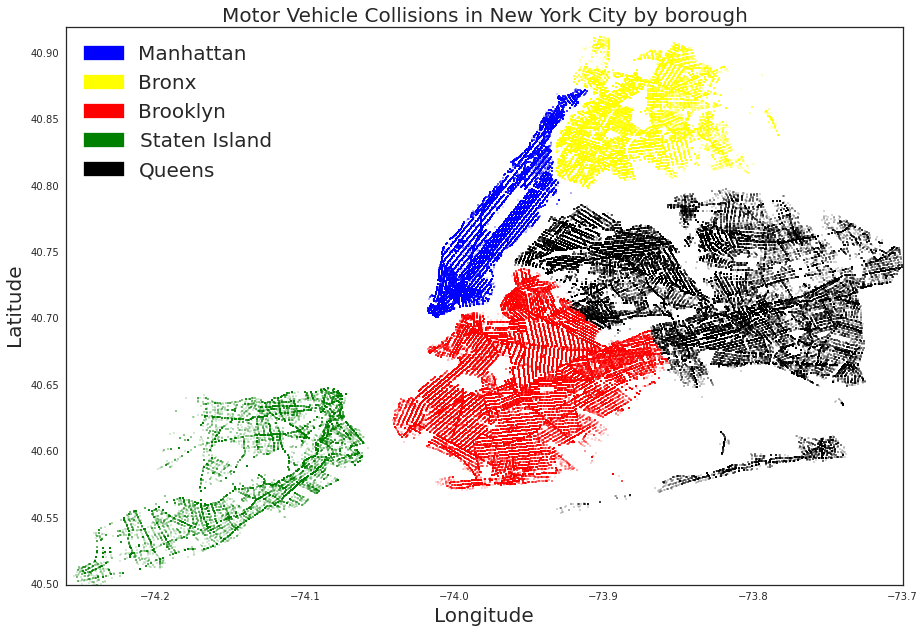

In [13]:
manhattan = collisions_pd[collisions_pd['Borough']=='MANHATTAN']
bronx = collisions_pd[collisions_pd['Borough']=='BRONX']
brooklyn = collisions_pd[collisions_pd['Borough']=='BROOKLYN']
staten = collisions_pd[collisions_pd['Borough']=='STATEN ISLAND']
queens = collisions_pd[collisions_pd['Borough']=='QUEENS']

plt.figure(figsize=(15,10), dpi=0.1)

#create scatterplots
plt.scatter(manhattan.Longitude, manhattan.Latitude, s=1, color='blue', marker ='.')
plt.scatter(bronx.Longitude, bronx.Latitude, s=1, color='yellow', marker ='.')
plt.scatter(brooklyn.Longitude, brooklyn.Latitude, color='red', s=1, marker ='.')
plt.scatter(staten.Longitude, staten.Latitude, s=1, color='green', marker ='.')
plt.scatter(queens.Longitude, queens.Latitude, s=1, color='black', marker ='.')

#create legend
blue_patch = mpatches.Patch(label='Manhattan', color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='Bronx')
red_patch = mpatches.Patch(color='red', label='Brooklyn')
green_patch = mpatches.Patch(color='green', label='Staten Island')
black_patch = mpatches.Patch(color='black', label='Queens')
plt.legend([blue_patch, yellow_patch, red_patch, green_patch, black_patch],
           ('Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City by borough', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

### Total number of collisions by borough
We can draw a bar graph showing the total number of collisions by borough.

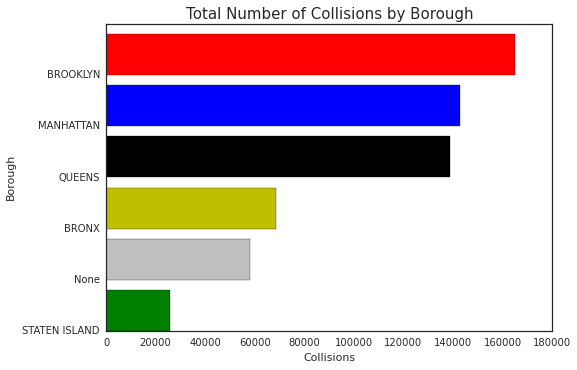

In [14]:
borough = collisions_df.groupBy('BOROUGH').count().sort('count').toPandas()
colors = ['g','0.75','y','k','b','r']
plt.barh(range(6),borough.sort('count', ascending=True)['count'], color=colors)
plt.xlabel('Collisions')
plt.ylabel('Borough')
plt.title('Total Number of Collisions by Borough', size=15)
plt.yticks(range(6), borough['BOROUGH'])
plt.show()

You will notice that the most collisions happen in Brooklyn and the least on Staten Island.

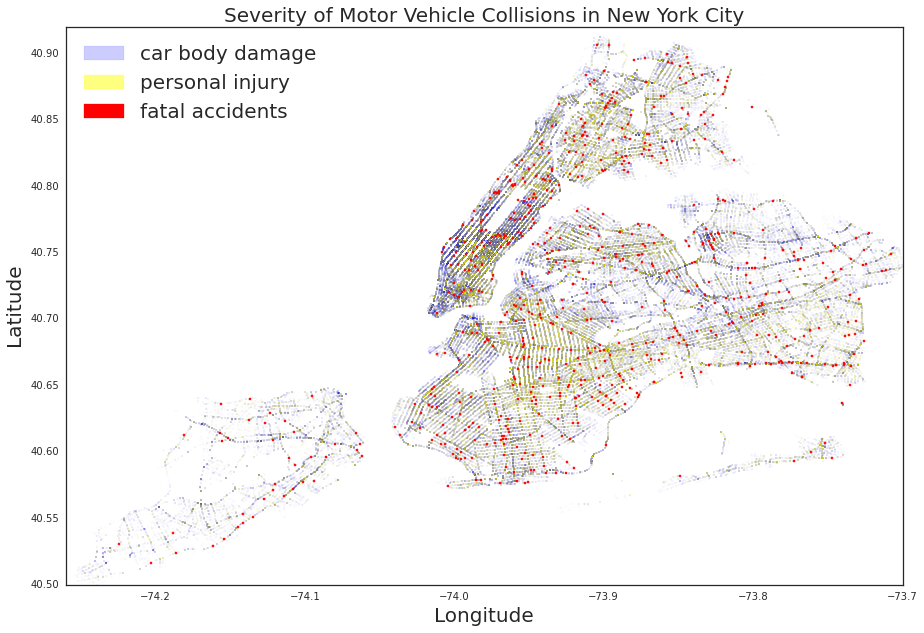

In [15]:
#adjust settings
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(nothing_pd.Longitude, nothing_pd.Latitude, alpha=0.04, s=1, color='blue')
plt.scatter(injured_pd.Longitude, injured_pd.Latitude, alpha=0.1, s=1, color='yellow')
plt.scatter(killed_pd.Longitude, killed_pd.Latitude, color='red', s=5)

#create legend
blue_patch = mpatches.Patch( label='car body damage', alpha=0.2, color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='personal injury', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='lethal accidents')
plt.legend([blue_patch, yellow_patch, red_patch],('car body damage', 'personal injury', 'fatal accidents'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Severity of Motor Vehicle Collisions in New York City', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.savefig('anothertry.png')

plt.show()

With color coding of collisions by car body damage, person injury and fatal accidents we can see that there are hot spots of fatal accidents in certain locations. We see that in some areas car body damage is prevalent, while in other areas person injury happens more often.

## Data Cleaning and Shaping
After the first explorative scatterplots over the raw data, we will now clean and shape the data set for more plots and further analysis. We start this process by having a look at the column names again, so we can assess which information we can use.

In [16]:
collisions_header_list

[u'DATE',
 u'TIME',
 u'BOROUGH',
 u'ZIP CODE',
 u'LATITUDE',
 u'LONGITUDE',
 u'LOCATION',
 u'ON STREET NAME',
 u'CROSS STREET NAME',
 u'OFF STREET NAME',
 u'NUMBER OF PERSONS INJURED',
 u'NUMBER OF PERSONS KILLED',
 u'NUMBER OF PEDESTRIANS INJURED',
 u'NUMBER OF PEDESTRIANS KILLED',
 u'NUMBER OF CYCLIST INJURED',
 u'NUMBER OF CYCLIST KILLED',
 u'NUMBER OF MOTORIST INJURED',
 u'NUMBER OF MOTORIST KILLED',
 u'CONTRIBUTING FACTOR VEHICLE 1',
 u'CONTRIBUTING FACTOR VEHICLE 2',
 u'CONTRIBUTING FACTOR VEHICLE 3',
 u'CONTRIBUTING FACTOR VEHICLE 4',
 u'CONTRIBUTING FACTOR VEHICLE 5',
 u'UNIQUE KEY',
 u'VEHICLE TYPE CODE 1',
 u'VEHICLE TYPE CODE 2',
 u'VEHICLE TYPE CODE 3',
 u'VEHICLE TYPE CODE 4',
 u'VEHICLE TYPE CODE 5']

We want to have entries with valid information about the street and borough, only.

In [17]:
collisions_df = collisions_df.dropna(how='any', subset=['ON STREET NAME', 'BOROUGH'])
collisions_df.count()

533885

### Spatial and temporal normalization using Spark
Because we want to have a more consistent representation for spatial and temporal information of collisions, we have to normalize it. This step will help for future investigations in which other data sets take part in the analysis as well.

In [18]:
# Define new schema
collisions_out_row = pyspark.sql.Row(*(["Time", "Street", "Borough"] + [c for c in collisions_header_list
                      if c not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]))
collisions_out_index = list(collisions_out_row)

collisions_out = collisions_df.map(
    lambda row: collisions_out_row(*(get_temporal(row) + get_spatial(row) + get_rest(row))))

def get_spatial(row):
    """
    Computes the location identifier from the input row

    Returns:
        List of spatial key columns
    """
    loc = normalize_street(row.__getattribute__("ON STREET NAME"))
    borough = row.__getattribute__("BOROUGH").lower()
    return [loc, borough]                    


def get_temporal(row):
    """
    Computes the temporal key from a given row
    """
    from datetime import datetime
    return [datetime(row.DATE.year, row.DATE.month, row.DATE.day, row.TIME.hour)]


def get_rest(row):
    return [row.__getattribute__(column) for column in collisions_header_list
             if column not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]

delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())

deltable = dict((ord(char), None) for char in delchars) # Python2 unicode

normalization_code = {
    'avenue':'av',
    'ave':'av',
    'avnue': 'av',
    'street': 'st',
    'road': 'rd',
    'boulevard': 'blvd',
    'place': 'pl',
    'plaza': 'pl',
    'square': 'sq',
    'drive': 'dr',
    'lane': 'ln',
    'parkway': 'pkwy',
    'turnpike': 'tp',
    'terrace': 'ter',
    '1st': '1',
    '2nd':'2',
    '3rd': '3',
    '1th': '1',
    '2th': '2',
    '3th': '3',
    '4th': '4',
    '5th': '5',
    '6th': '6',
    '7th': '7', 
    '8th': '8',
    '9th': '9',
    '0th': '0',
    'west ': 'w ',
    'north ': 'n ',
    'east ': 'e ',
    'south ': 's ',
}

def normalize_street(s):
    # Lowercase
    s = s.lower()

    # Delete all non-alphanumeric characters
    if isinstance(s, unicode):
        s = s.translate(deltable)
    else:
        s = s.translate(None, delchars) # Python 2

    # Replace common abbreviations
    for k in sorted(normalization_code.keys()):
        s = s.replace(k, normalization_code[k])

    # Only keep ascii chars
    s = s.encode('ascii', errors='ignore').decode()

    return s

## Investigating Variables

We have to investigate the variables and find out wheather they are useful or not. We begin with plotting one of the contributing factors.

### Contributing factors to collisions

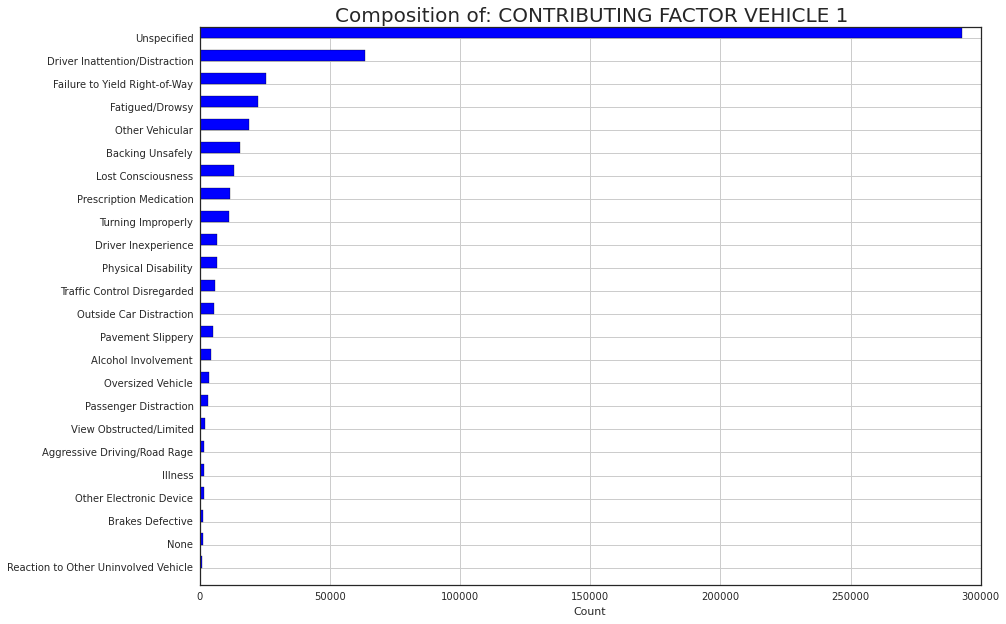

In [19]:
from pyspark.sql.functions import desc

collisions_out_df = collisions_out.toDF(sampleRatio=1)

factor = collisions_out_df.groupBy('CONTRIBUTING FACTOR VEHICLE 1').count().sort(desc('count')).toPandas()
factor = factor[0:24].sort(ascending=False)
factor.plot(kind='barh', legend=False, color='blue', figsize=(14,10))
plt.title('Composition of: ' + 'CONTRIBUTING FACTOR VEHICLE 1', size=20)
plt.xlabel('Count')
plt.yticks(range(len(factor))[::-1], factor['CONTRIBUTING FACTOR VEHICLE 1'][::-1])
plt.show()

Running the code cell above shows you that the contributing factor can't be specified in most cases. However, factors like distraction, failure to yield right-of-way and fatigue can play a role. You can investigate and plot the other contribution factos by modifying the code above.

### Sorting the vehicle types into groups

The data set has entries for a large number of car types. The following code cell regroups the car types into main categories like auto, bus, truck, taxi or other.

In [20]:
from collections import Counter

vehicletypecode, vehicletypecoderange = 'VEHICLE TYPE CODE ', range(1,6)
grouping = {
    'TAXI': 'Taxi',
    'AMBULANCE': 'Other',
    'BICYCLE': 'Other',
    'BUS': 'Bus',
    'FIRE TRUCK': 'Other', 
    'LARGE COM VEH(6 OR MORE TIRES)': 'Truck',
    'LIVERY VEHICLE': 'Truck',
    'MOTORCYCLE': 'Other', 
    'OTHER': 'Other',
    'PASSENGER VEHICLE': 'Auto',
    'PICK-UP TRUCK': 'Other',
    'PEDICAB': 'Other', 
    'SCOOTER': 'Other',
    'SMALL COM VEH(4 TIRES)': 'Truck',
    'SPORT UTILITY / STATION WAGON': 'Auto', 
    'UNKNOWN': 'Other',
    'VAN': 'Auto',
    'UNSPECIFIED': 'Other',
    None: None
}

collisions_out_categories = collisions_out.map(lambda row:
                   collisions_out_row(*[grouping[row[i]] if collisions_out_index[i].startswith("VEHICLE TYPE CODE")
                                                    else row[i] for i in range(len(row))])
                  )

In [21]:
collisions_transformed_row = pyspark.sql.Row(*(["Time", "Street", "Borough", "Injured",
                                                "Killed", "Auto", "Bus",
                                                "Truck", "Taxi", "Other", ]))

def transform_involved(row):
    counts = Counter([row[i] for i in range(len(row)) if collisions_out_index[i].startswith("VEHICLE TYPE CODE")])
    
    return collisions_transformed_row(*([row.__getattr__(c) for c in ["Time", "Street", "Borough",
                                                                      "NUMBER OF PERSONS INJURED",
                                                                      "NUMBER OF PERSONS KILLED"]] + 
                                       [counts[x] if x in counts else 0
                                           for x in ['Auto', 'Bus','Truck', 'Taxi', 'Other']]))

collisions_transformed = collisions_out_categories.map(transform_involved)

In [22]:
collisions_transformed_boolean_row = pyspark.sql.Row(*(["Time", "Street", "Borough",
                                                        "AccidentsWithInjuries",
                                                        "AccidentswithDeaths", "Auto", "Bus",
                                                        "Truck", "Taxi", "Other",
                                                        "Injured", "Killed"]))

collisions_transformed_boolean = collisions_transformed.map(
    lambda row: collisions_transformed_boolean_row(*([int(row.__getattr__(c) > 0) if c in ["Injured",
                                                "Killed"] else row.__getattr__(c)
                                                      for c in list(collisions_transformed_row)] + 
                                                    [row.Injured, row.Killed])))

Count the number of accidents by car type, severity, street and borough that occurred down to a time span of an hour.


In [23]:
aggregation_columns = {x:"sum" for x in ["AccidentsWithInjuries", "AccidentswithDeaths",
                                    "Auto", "Bus", "Truck", "Taxi", "Other", "Injured", "Killed"]}
aggregation_columns.update({"*":"count"})

collisions_grouped = collisions_transformed_boolean.toDF().groupBy(
    "Time", "Street", "Borough").agg(aggregation_columns)

for c in collisions_grouped.columns:
    if c.startswith("SUM"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, c[4:-1])
    elif c.startswith("COUNT"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, "NumberOfAccidents")

In [24]:
collisions_final_row = pyspark.sql.Row(*(["Year", "Month", "Day", "Hour"] + collisions_grouped.columns[1:]))
collisions_final = collisions_grouped.map(lambda row: collisions_final_row(*([row.Time.year, row.Time.month,
                                                                              row.Time.day, row.Time.hour] +
                                                                             [row.__getattribute__(x)
                                                                              for x in collisions_final_row[4:]])))

### Top 10 Streets with most collisions

Find the top 10 streets where the most collisions occurred. Display the results in a bar graph and as a scatter plot.

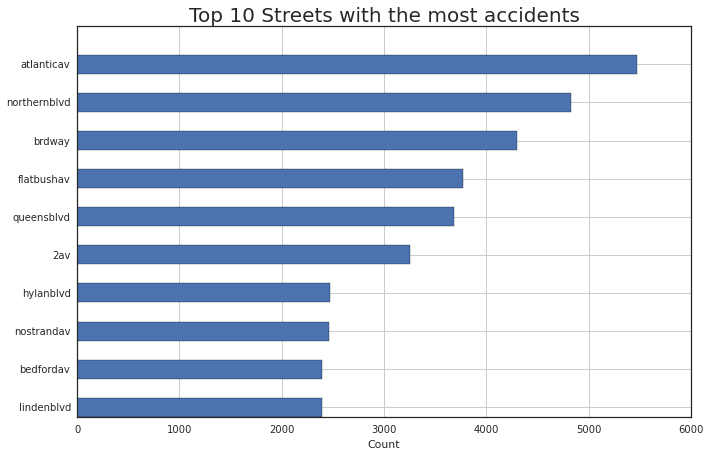

In [25]:
collisions_final_df = collisions_final.toDF()

from pyspark.sql.functions import udf, desc

plottingdf = collisions_final_df.groupBy("Borough", "Street").sum().sort(desc('SUM(NumberOfAccidents)')).\
limit(10).toPandas()
plottingdf[['SUM(NumberOfAccidents)']].plot(kind='barh', figsize=(11,7), legend=False)
plt.title('Top 10 Streets with the most accidents', size=20)
plt.xlabel('Count')
plt.yticks(range(10), plottingdf['Street'])
plt.gca().invert_yaxis()
plt.show()

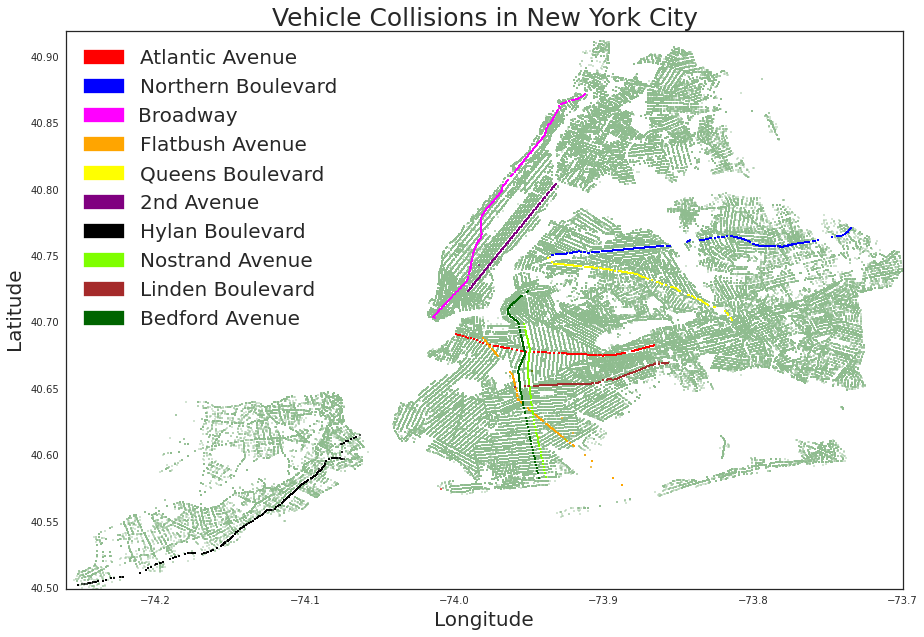

In [26]:
plt.figure(figsize=(15,10))

data1 = collisions_out_df[['Borough', 'Street', 'LATITUDE', 'LONGITUDE']].toPandas()

collisions1 = data1[np.logical_and(data1['Street']=='atlanticav', data1['Borough']=='brooklyn')]
collisions2 = data1[np.logical_and(data1['Street']=='northernblvd', data1['Borough']=='queens')]
collisions3 = data1[np.logical_and(data1['Street']=='brdway', data1['Borough']=='manhattan')]
collisions4 = data1[np.logical_and(data1['Street']=='flatbushav', data1['Borough']=='brooklyn')]
collisions5 = data1[np.logical_and(data1['Street']=='queensblvd', data1['Borough']=='queens')]
collisions6 = data1[np.logical_and(data1['Street']=='2av', data1['Borough']=='manhattan')]
collisions7 = data1[np.logical_and(data1['Street']=='hylanblvd', data1['Borough']=='staten island')]
collisions8 = data1[np.logical_and(data1['Street']=='nostrandav', data1['Borough']=='brooklyn')]
collisions9 = data1[np.logical_and(data1['Street']=='lindenblvd', data1['Borough']=='brooklyn')]
collisions10 = data1[np.logical_and(data1['Street']=='bedfordav', data1['Borough']=='brooklyn')]

#create scatterplots
plt.scatter(data1.LONGITUDE, data1.LATITUDE, s=1, color='darkseagreen')
plt.scatter(collisions1.LONGITUDE, collisions1.LATITUDE, s=2, color='red')
plt.scatter(collisions2.LONGITUDE, collisions2.LATITUDE, color='blue', s=2)
plt.scatter(collisions3.LONGITUDE, collisions3.LATITUDE, s=2, color='magenta')
plt.scatter(collisions4.LONGITUDE, collisions4.LATITUDE, color='orange', s=2)
plt.scatter(collisions5.LONGITUDE, collisions5.LATITUDE, s=2, color='yellow')
plt.scatter(collisions6.LONGITUDE, collisions6.LATITUDE, color='purple', s=2)
plt.scatter(collisions7.LONGITUDE, collisions7.LATITUDE, s=2, color='black')
plt.scatter(collisions8.LONGITUDE, collisions8.LATITUDE, color='chartreuse', s=2)
plt.scatter(collisions9.LONGITUDE, collisions9.LATITUDE, s=2, color='brown')
plt.scatter(collisions10.LONGITUDE, collisions10.LATITUDE, color='darkgreen', s=2)


#create legend
a_patch = mpatches.Patch(color='red', label='Atlantic Avenue')
b_patch = mpatches.Patch(color='blue', label='Northern Boulevard')
c_patch = mpatches.Patch(color='magenta', label='Broadway')
d_patch = mpatches.Patch(color='orange', label='Flatbush Avenue')
e_patch = mpatches.Patch(color='yellow', label='Queens Boulevard')
f_patch = mpatches.Patch(color='purple', label='2nd Avenue')
g_patch = mpatches.Patch(color='black', label='Hylan Boulevard')
h_patch = mpatches.Patch(color='chartreuse', label='Nostrand Avenue')
i_patch = mpatches.Patch(color='brown', label='Linden Boulevard')
j_patch = mpatches.Patch(color='darkgreen', label='Bedford Avenue')

plt.legend([a_patch, b_patch, c_patch, d_patch, e_patch, f_patch, g_patch, h_patch, i_patch, j_patch],
           ('Atlantic Avenue', 'Northern Boulevard', 'Broadway', 'Flatbush Avenue', 'Queens Boulevard', '2nd Avenue',
            'Hylan Boulevard', 'Nostrand Avenue', 'Linden Boulevard', 'Bedford Avenue'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

### Collisions throughout the day

Now we want to find out at what time of the day the most accidents occurred and see if we can detect any interesting 
patterns.

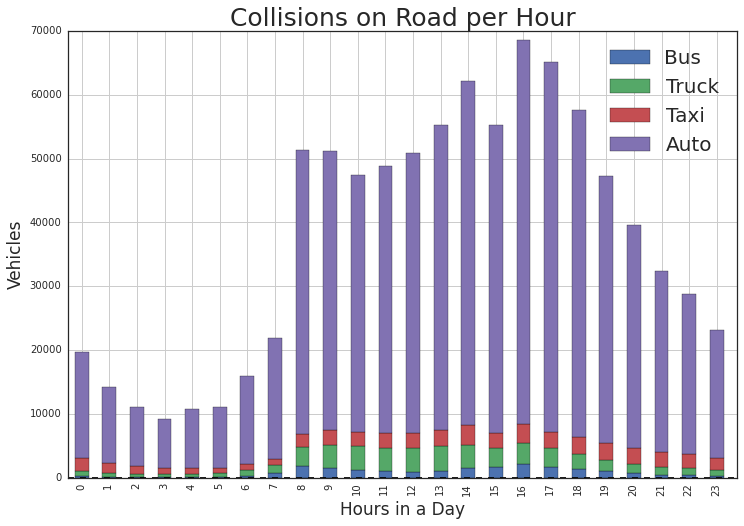

In [27]:
hourplot=collisions_final_df[['Bus','Truck','Taxi','Other','Hour','Auto']].groupBy('Hour').sum().toPandas()

hourplot[['Other', 'Bus', 'Truck', 'Taxi', 'Auto']] = hourplot[['SUM(Other)','SUM(Bus)','SUM(Truck)','SUM(Taxi)', 'SUM(Auto)']]
hourplot[['Bus', 'Truck', 'Taxi', 'Auto']].plot(stacked=True, kind='bar',figsize=(12,8), alpha=1)
#'SUM(Other)',
plt.xlabel('Hours in a Day', size=17)
plt.ylabel('Vehicles', size=17)
plt.legend(loc='best', prop={'size':20}, framealpha=0) 
plt.title('Collisions on Road per Hour', size=25)
plt.show()

This plot shows collisions over time of day with peaks for morning and afternoon rush hours. We can see that in the afternoon rush hour significantly more collisions occur than in the morning rush hour. We can also see that by far most collisions invovle autos, while busses and taxis and trucks are much less frequently involved.

## You want to know more?
Please check out our [Learning Center](https://developer.ibm.com/clouddataservices/docs/spark/) for more samples, tutorials, documentation, how-tos and blog posts.